<a href="https://www.kaggle.com/code/aisuko/fine-tuning-tst-models?scriptVersionId=198449662" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install -q transformers datasets evaluate accelerate "gluonts[torch]" ujson tqdm
!pip install -q protobuf --upgrade # without it, the evaluation code fails

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires protobuf<4,>3.12.2, but you have protobuf 5.28.2 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 5.28.2 which is incompatible.
google-cloud-aiplatform 0.6.0a1 requires google-api-core[grpc]<2.0.0dev,>=1.22.2, but you have google-api-core 2.11.1 which is incompatib

# Autoformer - Under The Hood

Autoformer builds upon the traditional method of decomposing time series into seasonality and trend-cycle components. This is achieved through the incorporation of a Decomposition Layer, which enhances the model's ability to capture these components accurately. Moreover, Autoformer introduces an innovative auto-correlation mechanism that replaces the standard self-attention used in the vanilla transformer. This mechanism enables the model to utilize period-based dependencies in the attention, thus improving the overall performance.


### Two key contributions of Autoformer

* The Decomposition Layer
* Attention(Autocorrelation) Mechanism


## Decomposition of Time Series

It is a method of breaking down a time series into three systematic components:


### The trend-cycle component

It represents the long-term direction of the time series, which can be increasing, decreasing or stable over time.

### The seasonal component

It represents the recurring patterns that occur within the time series, such as yearly or quarterly cycles.

### Random fluctuations component

It represents the random noise in the data that can't be explained by the trend or seasonal components.


Two main types of decomposition are additive and multiplicative decomposition, which are implemented in the great statsmodels library. By decomposing a time series into these components, we can better understand and model the underlying patterns in the data.

In [2]:
import torch
from torch import nn

class DecompositionLayer(nn.Module):
    """
    Returns the trend and the seasonal parts of the time series
    """
    
    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size=kernel_size
        self.avg=nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) # moving average
    
    def forward(self, x):
        """
        Input shape: Batch x Time x EMBED_DIM
        """
        # padding on the both ends of time series
        num_of_pads=(self.kernel_size-1)//2
        front=x[:,0.1,:].repeat(1, num_of_pads,1)
        end=x[:,-1:,:].repeat(1, num_of_pads,1)
        x_padded=torch.cat([front, x, end], dim=1)
        
        # calculate the trend and seasonal part of the series
        x_trend=self.avg(x_padded.permute(0,2,1)).permute(0,2,1)
        x_seasonal=x-x_trend
        return x_seasonal, x_trend

## Attention(Autocorrelation) Mechanism

**Autoformer employs a novel auto-correlation mechanism which replaces the self-attention seamlessly.** 

In [3]:
import torch 

def autocorrelation(query_states, key_states):
    """
    Computes autocorrelation(Q,K) using `torch.fft`. 
    Think about it as a replacement for the QK^T in the self-attention.
    
    Assumption: states are resized to same shape of [batch_size, time_length, embedding_dim].
    """
    query_states_fft = torch.fft.rfft(query_states, dim=1)
    key_states_fft = torch.fft.rfft(key_states, dim=1)
    attn_weights = query_states_fft * torch.conj(key_states_fft)
    attn_weights = torch.fft.irfft(attn_weights, dim=1)  
    
    return attn_weights

## Time Delay Aggregation

In [4]:
import torch
import math

def time_delay_aggregation(attn_weights, value_states, autocorrelation_factor=2):
    """
    Computes aggregation as value_states.roll(delay) * top_k_autocorrelations(delay).
    The final result is the autocorrelation-attention output.
    Think about it as a replacement of the dot-product between attn_weights and value states.
    
    The autocorrelation_factor is used to find top k autocorrelations delays.
    Assumption: value_states and attn_weights shape: [batch_size, time_length, embedding_dim]
    """
    bsz, num_heads, tgt_len, channel = ...
    time_length = value_states.size(1)
    autocorrelations = attn_weights.view(bsz, num_heads, tgt_len, channel)

    # find top k autocorrelations delays
    top_k = int(autocorrelation_factor * math.log(time_length))
    autocorrelations_mean = torch.mean(autocorrelations, dim=(1, -1))  # bsz x tgt_len
    top_k_autocorrelations, top_k_delays = torch.topk(autocorrelations_mean, top_k, dim=1)

    # apply softmax on the channel dim
    top_k_autocorrelations = torch.softmax(top_k_autocorrelations, dim=-1)  # bsz x top_k

    # compute aggregation: value_states.roll(delay) * top_k_autocorrelations(delay)
    delays_agg = torch.zeros_like(value_states).float()  # bsz x time_length x channel
    for i in range(top_k):
        value_states_roll_delay = value_states.roll(shifts=-int(top_k_delays[i]), dims=1)
        top_k_at_delay = top_k_autocorrelations[:, i]
        # aggregation
        top_k_resized = top_k_at_delay.view(-1, 1, 1).repeat(num_heads, tgt_len, channel)
        delays_agg += value_states_roll_delay * top_k_resized

    attn_output = delays_agg.contiguous()
    return attn_output

# Example: Traffic Dataset

We want to show empirically the performance of Transformer-based models in the library, by benchmarking on the traffic dataset, a dataset with 862 time series. We will train a shared model on each of the individual time series. Each time series represents the occupancy value of a sensor and is in the range [0,1].

In [5]:
# Traffic prediction_length is 24. Reference:
# https://github.com/awslabs/gluonts/blob/6605ab1278b6bf92d5e47343efcf0d22bc50b2ec/src/gluonts/dataset/repository/_lstnet.py#L105

prediction_length = 24
context_length = prediction_length*2
batch_size = 128
num_batches_per_epoch = 100
epochs = 50
scaling = "std"

encoder_layers=2
decoder_layers=2
d_model=16

## Load dataset

The traffic dataset, used by Lai et al. (2017), contains the San Francisco Traffic. It contains 862 hourly time series showing the road occupancy rates in the range  [0,1]  on the San Francisco Bay Area freeways from 2015 to 2016.

In [6]:
from gluonts.dataset.repository.datasets import get_dataset

dataset = get_dataset("traffic")
freq = dataset.metadata.freq
prediction_length = dataset.metadata.prediction_length
print(f"traffic dataset prediction_length: {prediction_length}")

/opt/conda/lib/python3.10/site-packages/gluonts/dataset/repository/_lstnet.py:133: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.period_range(


traffic dataset prediction_length: 24


/opt/conda/lib/python3.10/site-packages/gluonts/dataset/common.py:263: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.Period(val, freq)


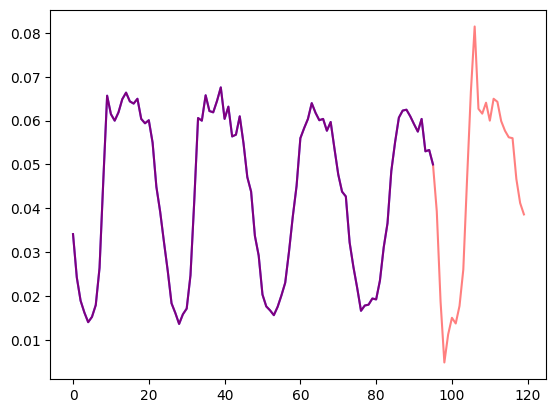

In [7]:
import matplotlib.pyplot as plt

train_example = next(iter(dataset.train))
test_example = next(iter(dataset.test))

num_of_samples = 4*prediction_length

figure, axes = plt.subplots()
axes.plot(train_example["target"][-num_of_samples:], color="blue")
axes.plot(
    test_example["target"][-num_of_samples - prediction_length :],
    color="red",
    alpha=0.5,
)

plt.show()

In [8]:
train_dataset = dataset.train
test_dataset = dataset.test

In [9]:
train_dataset

Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x7e2c30bb6bf0>, iterable=JsonLinesFile(path=PosixPath('/root/.gluonts/datasets/traffic/train/data.json.gz'), start=0, n=None, line_starts=[0, 96784, 193355, 290059, 386475, 482943, 579760, 676498, 772919, 869395, 966183, 1062803, 1159286, 1255957, 1352516, 1448908, 1545446, 1641629, 1738035, 1834571, 1930940, 2027988, 2124710, 2221284, 2317896, 2414170, 2510890, 2607306, 2703610, 2800254, 2896912, 2993625, 3090155, 3186593, 3283200, 3380007, 3476653, 3573415, 3670169, 3766766, 3863883, 3960682, 4057037, 4153752, 4250392, 4347148, 4443580, 4540428, 4636744, 4733469, 4830113, 4926697, 5023219, 5119708, 5216355, 5313205, 5409759, 5506306, 5603087, 5699840, 5796343, 5892675, 5989167, 6085606, 6182292, 6278789, 6375479, 6472124, 6568745, 6665561, 6762251, 6858913, 6955447, 7051935, 7145895, 7242438, 7338776, 7435425, 7531980, 7628781, 7725433, 7822185, 7918868, 8015406, 8111972, 8208744, 8305230, 8401735, 8498149, 8594979, 8691474, 

## Define transformations

Next, we define the transformations for the data, in particular for the creation of the time features (based on the dataset or universal ones).

We define a `Chain` of transformations from GluonTS(which is a bit comparable to torchvision.transforms.Compose for images). It allows us to combine several transformations into a single pipeline.

The transformations below are annotated with comments to explain what they do. At a high level, we will iterate over the individual time series of our dataset and add/remove fields or features:

In [10]:
from transformers import PretrainedConfig
from gluonts.time_feature import time_features_from_frequency_str

from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create a list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

## Define InstanceSplitter

The instance splitter samples random `context_length` sized and subsequent `prediction_length` sized windows from the data, and appends a `past_` or `future_` key to any temporal keys in `time_series_fields` for the respective windows. The instance splitter can be configured into three different modes:
1. `mode="train"`: Here we sample the context and prediction length windows randomly from the dataset given to it (the training dataset)
2. `mode="validation"`: Here we sample the very last context length window and prediction window from the dataset given to it (for the back-testing or validation likelihood calculations)
3. `mode="test"`: Here we sample the very last context length window only (for the prediction use case)

In [11]:
from gluonts.transform import InstanceSplitter
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

## Create PyTorch DataLoaders

Next, it's time to create PyTorch DataLoaders, which allow us to have batches of (input, output) pairs - or in other words (past_values, future_values).

In [12]:
from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )


def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # we create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )


def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

# Evalute on Autoformer

We have already pre-trained an Autoformer model on this dataset, so we can just fetch the model and evaluate it on the test set:

In [13]:
from transformers import AutoformerConfig, AutoformerForPrediction

config = AutoformerConfig.from_pretrained("kashif/autoformer-traffic-hourly")
model = AutoformerForPrediction.from_pretrained("kashif/autoformer-traffic-hourly")

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

config.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/116k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/gluonts/time_feature/_base.py:249: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = to_offset(freq_str)


At inference time, we will use the model's generate() method for predicting prediction_length steps into the future from the very last context window of each time series in the training set.

In [14]:
from accelerate import Accelerator

accelerator = Accelerator()
device = accelerator.device
print(device)
model.to(device)
model.eval()

forecasts_ = []
for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

cuda


The model outputs a tensor of shape (`batch_size`, `number of samples`, `prediction length`, `input_size`).

In this case, we get `100` possible values for the next `24` hours for each of the  time series in the test dataloader batch which if you recall from above is `64`:

In [15]:
forecasts_[0].shape

(64, 100, 24)

We'll stack them vertically, to get forecasts for all time-series in the test dataset: We have `7` rolling windows in the test set which is why we end up with a total of `7 * 862 = 6034` predictions:

In [16]:
import numpy as np

forecasts = np.vstack(forecasts_)
print(forecasts.shape)

(6034, 100, 24)


We can evaluate the resulting forecast with respect to the ground truth out of sample values present in the test set. For that, we'll use the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library, which includes the [MASE](https://huggingface.co/spaces/evaluate-metric/mase) metrics.

We calculate the metric for each time series in the dataset and return the average:

In [17]:
import warnings

# Ignore all FutureWarning messages
warnings.filterwarnings("ignore", category=FutureWarning)


In [18]:
from tqdm.autonotebook import tqdm
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
for item_id, ts in enumerate(tqdm(test_dataset)):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])

  0%|          | 0/6034 [00:00<?, ?it/s]

In [19]:
print(f"Autoformer univariate MASE: {np.mean(mase_metrics):.3f}")

Autoformer univariate MASE: 0.849


To plot the prediction for any time series with respect to the ground truth test data, we define the following helper:

In [20]:
import matplotlib.dates as mdates
import pandas as pd

test_ds = list(test_dataset)

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_ds[ts_index][FieldName.START],
        periods=len(test_ds[ts_index][FieldName.TARGET]),
        freq=test_ds[ts_index][FieldName.START].freq,
    ).to_timestamp()

    ax.plot(
        index[-5*prediction_length:],
        test_ds[ts_index]["target"][-5*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:],
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )

    plt.gcf().autofmt_xdate()
    plt.legend(loc="best")
    plt.show()

# Evaluate on DLinear

A probabilistic DLinear is implemented in `gluonts` and thus we can train and evaluate it relatively quickly here:

In [21]:
from gluonts.torch.model.d_linear.estimator import DLinearEstimator

# Define the DLinear model with the same parameters as the Autoformer model
estimator = DLinearEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    scaling=scaling,
    hidden_dimension=2,

    batch_size=batch_size,
    num_batches_per_epoch=num_batches_per_epoch,
    trainer_kwargs=dict(max_epochs=epochs)
)

In [22]:
predictor = estimator.train(
    training_data=train_dataset,
    cache_data=True,
    shuffle_buffer_length=1024
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type         | Params
---------------------------------------
0 | model | DLinearModel | 4.7 K 
---------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 100: 'train_loss' reached -2.37162 (best -2.37162), saving model to '/kaggle/working/lightning_logs/version_0/checkpoints/epoch=0-step=100.ckpt' as top 1
INFO: Epoch 1, global step 200: 'train_loss' reached -2.66804 (best -2.66804), saving model to '/kaggle/working/lightning_logs/version_0/checkpoints/epoch=1-step=200.ckpt' as top 1
INFO: Epoch 2, global step 300: 'train_loss' reached -2.76997 (best -2.76997), saving model to '/kaggle/working/lightning_logs/version_0/checkpoints/epoch=2-step=300.ckpt' as top 1
INFO: Epoch 3, global step 400: 'train_loss' reached -2.83442 (best -2.83442), saving model to '/kaggle/working/lightning_logs/version_0/checkpoints/epoch=3-step=400.ckpt' as top 1
INFO: Epoch 4, global step 500: 'train_loss' reached -2.87534 (best -2.87534), saving model to '/kaggle/working/lightning_logs/version_0/checkpoints/epoch=4-step=500.ckpt' as top 1
INFO: Epoch 5, global step 600: 'train_loss' reached -2.88806 (best -2.88806), saving model to 

In [23]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

d_linear_forecasts = list(forecast_it)
d_linear_tss = list(ts_it)

evaluator = Evaluator()

agg_metrics, _ = evaluator(iter(d_linear_tss), iter(d_linear_forecasts))

Running evaluation: 6034it [00:00, 106921.07it/s]
/opt/conda/lib/python3.10/site-packages/gluonts/evaluation/_base.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/opt/conda/lib/python3.10/site-packages/gluonts/evaluation/_base.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/opt/conda/lib/python3.10/site-packages/gluonts/evaluation/_base.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/opt/conda/lib/python3.10/site-packages/gluonts/evaluation/_base.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [24]:
dlinear_mase = agg_metrics["MASE"]
print(f"DLinear MASE: {dlinear_mase:.3f}")

DLinear MASE: 0.967


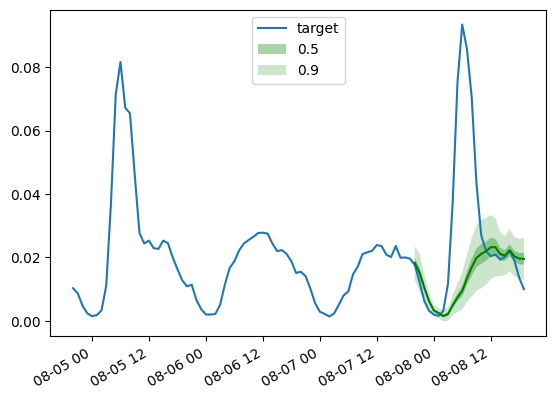

In [25]:
def plot_gluonts(index):
    plt.plot(d_linear_tss[index][-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target")
    d_linear_forecasts[index].plot(show_label=True,  color='g')
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()
    
plot_gluonts(4)

The traffic dataset has a distributional shift in the sensor patterns between weekdays and weekends. So what is going on here? Since the DLinear model has no capacity to incorporate covariates, in particular any date-time features, the context window we give it does not have enough information to figure out if the prediction is for the weekend or weekday. Thus, the model will predict the more common of the patterns, namely the weekdays leading to poorer performance on weekends. Of course, by giving it a larger context window, a linear model will figure out the weekly pattern, but perhaps there is a monthly or quarterly pattern in the data which would require bigger and bigger contexts.

# Acknowledgement

* https://huggingface.co/blog/autoformer
* https://huggingface.co/blog/time-series-transformers
* https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/autoformer-transformers-are-effective.ipynb#scrollTo=o9KmCEu7OJmf
* https://github.com/amazon-science/chronos-forecasting
* https://ts.gluon.ai/stable/